## Setup

In [1]:
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import random
import numpy as np
import pandas as pd
import tensorflow as tf
import isuelogit as isl
import seaborn as sns
from sklearn import preprocessing
from datetime import datetime

In [2]:
# Path management
main_dir = str(Path(os.path.abspath('')).parents[1])
os.chdir(main_dir)
print('main dir:', main_dir)

isl.config.dirs['read_network_data'] = "input/network-data/fresno/"

main dir: /Users/pablo/Library/CloudStorage/OneDrive-Personal/data-science/github/gisuelogit


In [3]:
# Internal modules
from src.gisuelogit.visualizations import plot_predictive_performance, plot_heatmap_demands, plot_convergence_estimates
from src.gisuelogit.models import UtilityParameters, GISUELOGIT, AETSUELOGIT, NGD, BPRParameters, ODParameters
from src.gisuelogit.networks import load_k_shortest_paths, build_tntp_network, Equilibrator, ColumnGenerator
from src.gisuelogit.etl import get_design_tensor, get_y_tensor, simulate_suelogit_data
from src.gisuelogit.descriptive_statistics import mse, btcg_mse, mnrmse, nrmse

In [4]:
# Seed for reproducibility
_SEED = 2022
np.random.seed(_SEED)
random.seed(_SEED)
tf.random.set_seed(_SEED)

## Build network

In [5]:
network_name = 'SiouxFalls'
tntp_network = build_tntp_network(network_name=network_name)

## Read OD matrix

In [6]:
Q = isl.reader.read_tntp_od(network_name=network_name)
tntp_network.load_OD(Q=Q)

Reading Q from external file
Matrix Q (24, 24) read in 0.5[s]                        

360600.0 trips were loaded among 528 o-d pairs


## Read paths

In [7]:
load_k_shortest_paths(network=tntp_network, k=2, update_incidence_matrices=True)

Generating at most 2 paths per od
1056 paths were generated among 528 od pairs in 0.9 [s]

1056 paths were loaded in the network
Matrix D (76, 1056) generated in 1.3[s]               

Matrix M (528, 1056) generated in 0.7[s]               

Matrix C (1056, 1056) generated in 0.0[s]               



## Read data

In [8]:
# Synthethic data which was generated under the assumption of path sets of size 2.

df = pd.read_csv(
    main_dir + '/output/network-data/' + tntp_network.key + '/links/' + tntp_network.key + '-link-data.csv')

## Utility function

In [9]:
features_Z = ['c', 's']

n_sparse_features = 0
features_sparse = ['k' + str(i) for i in np.arange(0, n_sparse_features)]
features_Z.extend(features_sparse)

## Training and validation sets

In [10]:
n_days = len(df.period.unique())
n_links = len(tntp_network.links)
n_hours = 1

# Add free flow travel times
df['tt_ff'] = np.tile([link.bpr.tf for link in tntp_network.links], n_days)

traveltime_data = get_design_tensor(y=df['traveltime'], n_links=n_links, n_days=n_days, n_hours=n_hours)
flow_data = get_y_tensor(y=df[['counts']], n_links=n_links, n_days=n_days, n_hours=n_hours)

Y = tf.concat([traveltime_data, flow_data], axis=3)
X = get_design_tensor(Z=df[features_Z], n_links=n_links, n_days=n_days, n_hours=n_hours)

X_train, X_test, Y_train, Y_test = train_test_split(X.numpy(), Y.numpy(), test_size=0.2, random_state=_SEED)

X_train, X_test, Y_train, Y_test = [tf.constant(i) for i in [X_train, X_test, Y_train, Y_test]]

2022-10-21 11:29:23.656178: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Configuration

In [11]:
_EPOCHS = {'learning': 10, 'equilibrium': 2}
_LR = 1e-1
_RELATIVE_GAP = 1e-8
_BATCH_SIZE = 16
_EPOCHS_PRINT_INTERVAL = 50

_MOMENTUM_EQUILIBRIUM = 1

_LOSS_METRIC = mse
#_LOSS_METRIC  = btcg_mse
#_LOSS_METRIC  = mnrmse
#_LOSS_METRIC  = nrmse

_LOSS_WEIGHTS ={'od': 1, 'tt': 1, 'flow': 1, 'eq_flow': 1}

## Models

In [12]:
list_models = ['equilibrium','lue', 'ode', 'lpe', 'odlue', 'odlulpe']

run_model = dict.fromkeys(list_models,True)
#run_model = dict.fromkeys(list_models, False)

# run_model['equilibrium'] = True
# run_model['lue'] = True
# run_model['ode'] = True
# run_model['lpe'] = True
# run_model['odlue'] = True
# run_model['odlulpe'] = True


In [13]:
train_results_dfs = {}
val_results_dfs = {}

### Model 1: Equilibrium

ISUELOGIT: Equilibrium

Epoch: 0, n_train: 80, n_test: 20

0: train_loss=6.9e+07, val_loss=6.9e+07, train_loss tt=1.1e+04, val_loss tt=1.1e+04, train_loss flow=1.7e+07, val_loss flow=1.7e+07, theta = [-1. -6. -3.], vot = 0.17, psc_factor = 0.0, avg abs theta fixed effect = 0, avg alpha=0.15, avg beta=4, loss demand=1.3e-26, lambda eq=1, relative x=0.71, relative gap=1e-08, train flow equilibrium loss=6.9e+07, time: 0.3

Epoch: 1, n_train: 80, n_test: 20

1: train_loss=6.7e+07, val_loss=6.7e+07, train_loss tt=1.1e+04, val_loss tt=1.1e+04, train_loss flow=1.7e+07, val_loss flow=1.7e+07, theta = [-1. -6. -3.], vot = 0.17, psc_factor = 0.0, avg abs theta fixed effect = 0, avg alpha=0.15, avg beta=4, loss demand=1.3e-26, lambda eq=1, relative x=0.7, relative gap=-0.0076, train flow equilibrium loss=6.7e+07, time: 0.6

Epoch: 10, n_train: 80, n_test: 20

10: train_loss=4.3e+07, val_loss=4.3e+07, train_loss tt=7e+03, val_loss tt=7e+03, train_loss flow=1.3e+07, val_loss flow=1.3e+07, theta = [

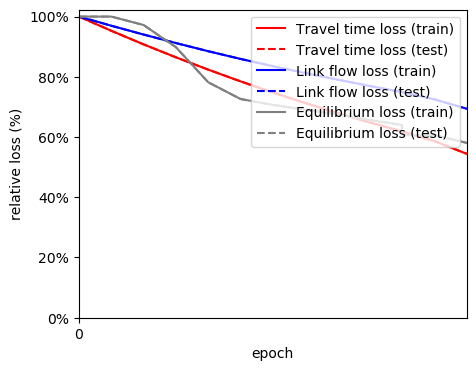

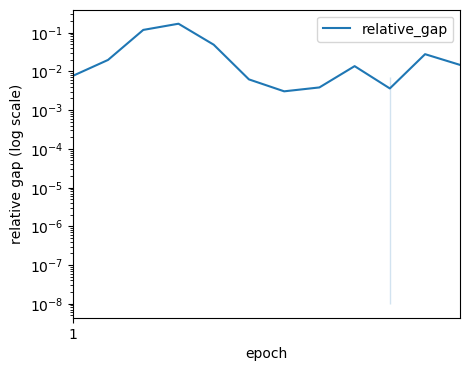

In [14]:
if run_model['equilibrium']:

    # _RELATIVE_GAP = 1e-8

    optimizer = tf.keras.optimizers.Adam(learning_rate=_LR)

    print('ISUELOGIT: Equilibrium')

    utility_parameters = UtilityParameters(features_Y=['tt'],
                                           features_Z=features_Z,
                                           periods=1,
                                           initial_values={'tt': -1, 'c': -6, 's': -3, 'psc_factor': 0,
                                                           'fixed_effect': np.zeros_like(tntp_network.links)},
                                           trainables={'psc_factor': False, 'fixed_effect': False
                                               , 'tt': False, 'c': False, 's': False},
                                           )

    bpr_parameters = BPRParameters(keys=['alpha', 'beta'],
                                   initial_values={'alpha': 0.15, 'beta': 4},
                                   # initial_values={'alpha': 1, 'beta': 1},
                                   trainables=dict.fromkeys(['alpha', 'beta'], False),
                                   )

    od_parameters = ODParameters(key='od',
                                 periods=1,
                                 # initial_values=0.6 * tntp_network.q.flatten(),
                                 initial_values=tntp_network.q.flatten(),
                                 true_values=tntp_network.q.flatten(),
                                 historic_values={1: tntp_network.q.flatten()},
                                 trainable=False)

    len(tntp_network.q.flatten())

    # q_historic = isl.networks.denseQ(isl.factory.random_disturbance_Q(tntp_network.Q, sd=np.mean(tntp_network.Q) * 0.05).copy())

    q_historic = tntp_network.q

    equilibrator = Equilibrator(
        network=tntp_network,
        # paths_generator=paths_generator,
        utility=utility_parameters,
        max_iters=100,
        method='fw',
        iters_fw=50,
        accuracy=1e-4,
    )

    suelogit = GISUELOGIT(
        key='suelogit',
        # endogenous_flows=True,
        network=tntp_network,
        dtype=tf.float64,
        equilibrator=equilibrator,
        # column_generator=column_generator,
        utility=utility_parameters,
        bpr=bpr_parameters,
        od=od_parameters
    )

    train_results_dfs['suelogit'], val_results_dfs['suelogit'] = suelogit.train(
        X_train, Y_train, X_test, Y_test,
        # generalization_error={'train': False, 'validation': True},
        # loss_metric = mse,
        loss_metric=_LOSS_METRIC,
        optimizer=optimizer,
        batch_size=_BATCH_SIZE,
        loss_weights={'od': 0, 'theta': 0, 'tt': 0, 'flow': 0, 'eq_flow': 1},
        threshold_relative_gap=_RELATIVE_GAP,
        epochs_print_interval = _EPOCHS_PRINT_INTERVAL,
        epochs=_EPOCHS)

    train_results_estimates, train_results_losses = suelogit.split_results(results=train_results_dfs['suelogit'])
    val_results_estimates, val_results_losses = suelogit.split_results(results=val_results_dfs['suelogit'])

    plot_predictive_performance(train_losses=train_results_dfs['suelogit'], val_losses=val_results_dfs['suelogit'],xticks_spacing= 50)

    fig, ax = plot_convergence_estimates(
        estimates=train_results_losses.drop([0]).assign(
            relative_gap = np.abs(train_results_losses['relative_gap']))[['epoch','relative_gap']],
    xticks_spacing= 50)

    ax.set_yscale('log')
    ax.set_ylabel('relative gap (log scale)')

    plt.show()

### Model 2: Benchmark of gisuelogit and isuelogit


LUE: Benchmark of gisuelogit and isuelogit (utility only)
Mean of nonzero entries in the original demand matrix:  683.0
Mean absolute difference between the nonzero entries of the noisy and original: 45.9
Approximated proportion change: 6.7%

Epoch: 0, n_train: 80, n_test: 20

0: train_loss=8.5e+07, val_loss=8.5e+07, train_loss tt=1.1e+04, val_loss tt=1.1e+04, train_loss flow=1.7e+07, val_loss flow=1.7e+07, theta = [-1. -6. -3.], vot = 0.17, psc_factor = 0.0, avg abs theta fixed effect = 0, avg alpha=0.15, avg beta=4, loss demand=1.3e-26, lambda eq=1, relative x=0.72, relative gap=1e-08, train flow equilibrium loss=6.8e+07, time: 0.3

Epoch: 1, n_train: 80, n_test: 20

1: train_loss=1.9e+07, val_loss=1.9e+07, train_loss tt=1e+04, val_loss tt=1e+04, train_loss flow=1.7e+07, val_loss flow=1.7e+07, theta = [-0.5307 -6.4758 -3.4852], vot = 0.08, psc_factor = 0.0, avg abs theta fixed effect = 0, avg alpha=0.15, avg beta=4, loss demand=1.3e-26, lambda eq=0.25, relative x=0.67, relative gap=

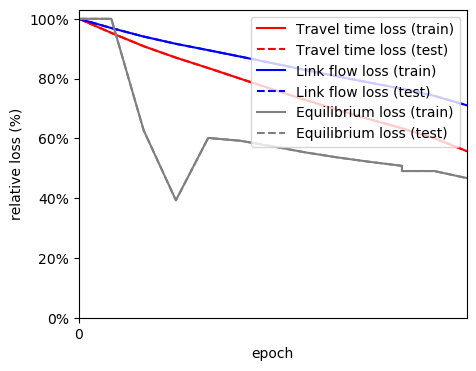

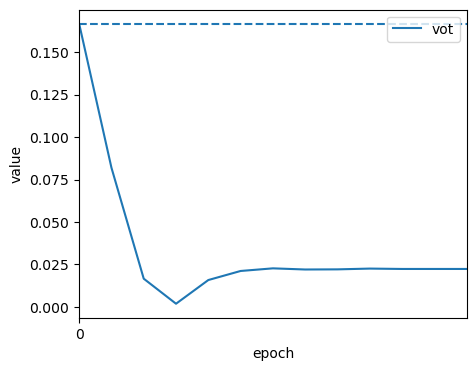

theta = {'tt': -0.18805578253999933, 'c': -8.406035100575455, 's': -5.253683343673189}, vot = 0.02
alpha =  0.15, beta  =  4.00
Avg abs diff of observed and estimated OD:  45.88


In [15]:
if run_model['lue']:
    print('\nLUE: Benchmark of gisuelogit and isuelogit (utility only)')

    # optimizer = NGD(learning_rate=_LR)
    # optimizer = tf.keras.optimizers.SGD(learning_rate=_LR)

    # Initialize again the optimizer as there are some decay parameters that are stored in the object and that will
    # affect the next model estimation
    optimizer = tf.keras.optimizers.Adam(learning_rate=_LR)

    # _RELATIVE_GAP = 1e-8

    utility_parameters = UtilityParameters(features_Y=['tt'],
                                           features_Z=features_Z,
                                           periods=1,
                                           initial_values={'tt': 0, 'c': 0, 's': 0, 'psc_factor': 0,
                                                           'fixed_effect': np.zeros_like(tntp_network.links)},
                                           true_values={'tt': -1, 'c': -6, 's': -3},
                                           trainables={'psc_factor': False, 'fixed_effect': False
                                               , 'tt': True, 'c': True, 's': True},
                                           )

    utility_parameters.random_initializer((0,0),['tt','c','s'])
    # utility_parameters.initial_values = dict(utility_parameters.initial_values, tt = -1, c = -1, s = -1)

    bpr_parameters = BPRParameters(keys=['alpha', 'beta'],
                                   initial_values={'alpha': 0.15, 'beta': 4},
                                   # initial_values={'alpha': 1, 'beta': 1},
                                   trainables=dict.fromkeys(['alpha', 'beta'], False))

    q_historic = isl.networks.denseQ(isl.factory.random_disturbance_Q(tntp_network.Q, sd=np.mean(tntp_network.Q) * 0.1).copy())

    # q_historic = tntp_network.q

    od_parameters = ODParameters(key='od',
                                 periods=1,
                                 # initial_values=0.6 * tntp_network.q.flatten(),
                                 # initial_values=tntp_network.q.flatten(),
                                 # true_values=tntp_network.q.flatten(),
                                 initial_values=q_historic.flatten(),
                                 historic_values={1: q_historic.flatten()},
                                 # historic_values={1: tntp_network.q.flatten()},
                                 trainable=False)

    equilibrator = Equilibrator(
        network=tntp_network,
        # paths_generator=paths_generator,
        utility=utility_parameters,
        max_iters=100,
        method='fw',
        iters_fw=50,
        accuracy=1e-4,
    )

    lue = GISUELOGIT(
        key='lue',
        # endogenous_flows=True,
        network=tntp_network,
        dtype=tf.float64,
        equilibrator=equilibrator,
        # column_generator=column_generator,
        utility=utility_parameters,
        bpr=bpr_parameters,
        od=od_parameters
    )

    train_results_dfs['lue'], val_results_dfs['lue'] = lue.train(
        X_train, Y_train, X_test, Y_test,
        # generalization_error={'train': False, 'validation': True},
        optimizer=optimizer,
        batch_size=_BATCH_SIZE,
        loss_metric=_LOSS_METRIC,
        loss_weights= dict(_LOSS_WEIGHTS),
        momentum_equilibrium = _MOMENTUM_EQUILIBRIUM,
        threshold_relative_gap=_RELATIVE_GAP,
        epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
        epochs=_EPOCHS)

    train_results_estimates, train_results_losses = lue.split_results(results=train_results_dfs['lue'])
    val_results_estimates, val_results_losses = lue.split_results(results=val_results_dfs['lue'])

    plot_predictive_performance(train_losses=train_results_losses, val_losses=val_results_losses,
                                xticks_spacing=250)

    plot_convergence_estimates(estimates=train_results_estimates.\
                               assign(vot = train_results_estimates['tt']/train_results_estimates['c'])[['epoch','vot']],
                               true_values={'vot':lue.utility.true_values['tt']/lue.utility.true_values['c']},
                                xticks_spacing=250)

    plt.show()



    print(f"theta = {dict(zip(utility_parameters.true_values.keys(), list(lue.theta.numpy())))}, "
          f"vot = {train_results_estimates.eval('tt/c').values[-1]:0.2f}")
    print(f"alpha = {lue.alpha: 0.2f}, beta  = {lue.beta: 0.2f}")
    print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(lue.q - tntp_network.q.flatten())): 0.2f}")

### Model 3: estimation of link performance parameters (LPE)


LPE: link performance estimation
Mean of nonzero entries in the original demand matrix:  680.6
Mean absolute difference between the nonzero entries of the noisy and original: 49.7
Approximated proportion change: 7.3%

Epoch: 0, n_train: 80, n_test: 20

0: train_loss=8.7e+07, val_loss=8.7e+07, train_loss tt=1.1e+04, val_loss tt=1.1e+04, train_loss flow=1.8e+07, val_loss flow=1.8e+07, theta = [-1. -6. -3.], vot = 0.17, psc_factor = 0.0, avg abs theta fixed effect = 0, avg alpha=0.15, avg beta=4, loss demand=1.2e-26, lambda eq=1, relative x=0.74, relative gap=1e-08, train flow equilibrium loss=6.9e+07, time: 0.3

Epoch: 1, n_train: 80, n_test: 20

1: train_loss=1.6e+07, val_loss=1.6e+07, train_loss tt=35, val_loss tt=35, train_loss flow=1.7e+07, val_loss flow=1.7e+07, theta = [-1. -6. -3.], vot = 0.17, psc_factor = 0.0, avg abs theta fixed effect = 0, avg alpha=0.093, avg beta=2.5, loss demand=1.2e-26, lambda eq=0.33, relative x=0.43, relative gap=-0.5, train flow equilibrium loss=3.1e+0

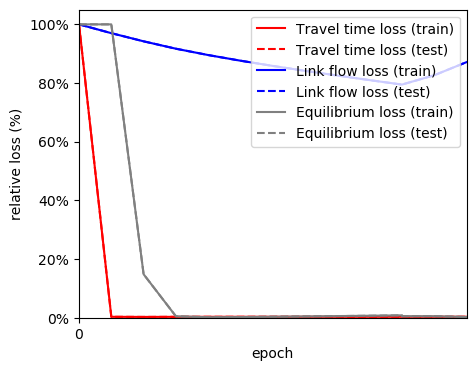

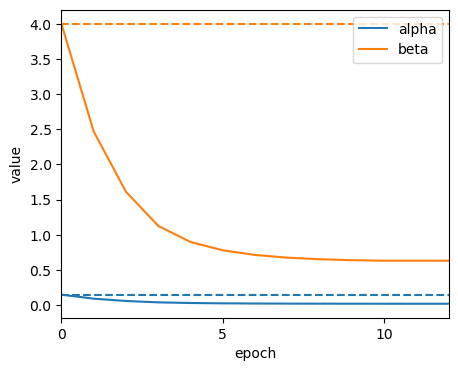

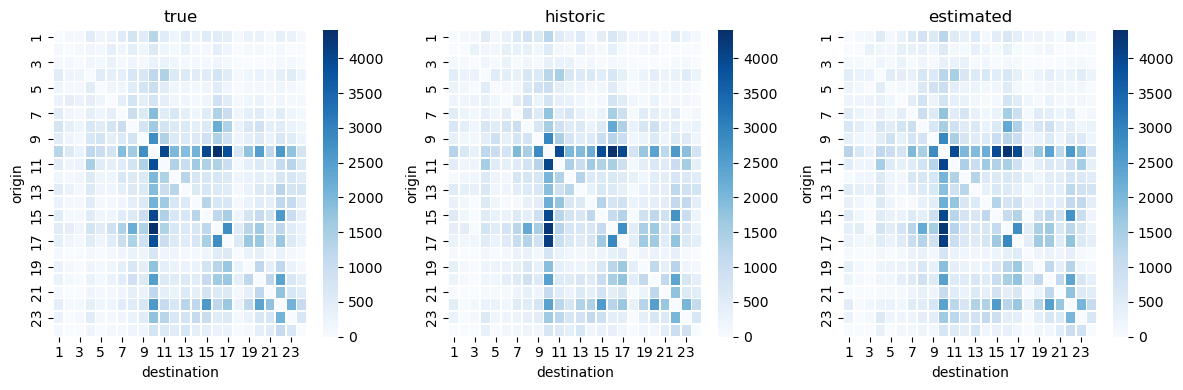

theta = {'tt': -1.0, 'c': -6.0, 's': -3.0}
alpha =  0.02, beta  =  0.63
Avg abs diff of observed and estimated OD:  67.16


In [16]:
if run_model['lpe']:
    print('\nLPE: link performance estimation')

    # _RELATIVE_GAP = 1e-8

    optimizer = tf.keras.optimizers.Adam(learning_rate=_LR)

    # optimizer = NGD(learning_rate=_LR)

    utility_parameters = UtilityParameters(features_Y=['tt'],
                                           features_Z=features_Z,
                                           periods=1,
                                           initial_values={'tt': -1, 'c': -6, 's': -3, 'psc_factor': 0,
                                                           'fixed_effect': np.zeros_like(tntp_network.links)},
                                           trainables={'psc_factor': False, 'fixed_effect': False
                                               , 'tt': False, 'c': False, 's': False},
                                           )

    utility_parameters.random_initializer((0,0),['tt','c','s'])

    bpr_parameters = BPRParameters(keys=['alpha', 'beta'],
                                   initial_values={'alpha': 1, 'beta': 2},
                                   true_values={'alpha': 0.15, 'beta': 4},
                                   trainables=dict.fromkeys(['alpha', 'beta'], True),
                                   # trainables={'alpha': False, 'beta': True}
                                   )

    bpr_parameters.random_initializer((0,0),['alpha','beta'])


    Q_historic = isl.factory.random_disturbance_Q(tntp_network.Q, sd=np.mean(tntp_network.Q) * 0.1).copy()
    # Q_historic = tntp_network.Q.copy()

    od_parameters = ODParameters(key='od',
                                 periods=1,
                                 # initial_values=tntp_network.q.flatten(),
                                 initial_values= isl.networks.denseQ(Q_historic).flatten(),
                                 # initial_values=np.ones_like(tntp_network.q.flatten()),
                                 historic_values={1: isl.networks.denseQ(Q_historic).flatten()},
                                 # historic_values={1: tntp_network.q.flatten()},
                                 trainable=False)

    equilibrator = Equilibrator(
        network=tntp_network,
        # paths_generator=paths_generator,
        utility=utility_parameters,
        max_iters=100,
        method='fw',
        iters_fw=50,
        accuracy=1e-4,
    )

    lpe = GISUELOGIT(
        key='lpe',
        network=tntp_network,
        dtype=tf.float64,
        equilibrator=equilibrator,
        utility=utility_parameters,
        bpr=bpr_parameters,
        od=od_parameters,
    )

    train_results_dfs['lpe'], val_results_dfs['lpe'] = lpe.train(
        X_train, Y_train, X_test, Y_test,
        optimizer=optimizer,
        batch_size=_BATCH_SIZE,
        loss_metric=_LOSS_METRIC,
        # loss_metric=mnrmse,
        # generalization_error={'train': False, 'validation': True},
        loss_weights= dict(_LOSS_WEIGHTS, od = 0),
        momentum_equilibrium = _MOMENTUM_EQUILIBRIUM,
        threshold_relative_gap=_RELATIVE_GAP,
        epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
        epochs=_EPOCHS)

    train_results_estimates, train_results_losses = lpe.split_results(results=train_results_dfs['lpe'])
    val_results_estimates, val_results_losses = lpe.split_results(results=val_results_dfs['lpe'])

    plot_predictive_performance(train_losses= train_results_losses, val_losses=val_results_dfs['lpe'],
                                xticks_spacing = 250)

    plot_convergence_estimates(estimates=train_results_estimates[['epoch','alpha','beta']],
                               true_values=lpe.bpr.true_values)

    Qs = {'true': tntp_network.OD.Q_true, 'historic': Q_historic, 'estimated': tf.sparse.to_dense(lpe.Q).numpy()}

    plot_heatmap_demands(Qs=Qs, vmin=np.min(Qs['true']), vmax=np.max(Qs['true']), subplots_dims=(1, 3), figsize=(12, 4))

    plt.show()

    print(f"theta = {dict(zip(utility_parameters.true_values.keys(), list(lpe.theta.numpy())))}")
    print(f"alpha = {lpe.alpha: 0.2f}, beta  = {lpe.beta: 0.2f}")
    print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(lpe.q - tntp_network.q.flatten())): 0.2f}")

## Model 3: ODE with historic OD


 ODE: OD estimation with historic OD
Mean of nonzero entries in the original demand matrix:  682.3
Mean absolute difference between the nonzero entries of the noisy and original: 47.7
Approximated proportion change: 7.0%

Epoch: 0, n_train: 80, n_test: 20

0: train_loss=8.9e+07, val_loss=8.9e+07, train_loss tt=1.2e+04, val_loss tt=1.2e+04, train_loss flow=1.8e+07, val_loss flow=1.8e+07, theta = [-1. -6. -3.], vot = 0.17, psc_factor = 0.0, avg abs theta fixed effect = 0, avg alpha=0.15, avg beta=4, loss demand=1.4e-26, lambda eq=1, relative x=0.76, relative gap=1e-08, train flow equilibrium loss=7.1e+07, time: 0.3

Epoch: 1, n_train: 80, n_test: 20

1: train_loss=2.1e+07, val_loss=2.1e+07, train_loss tt=1.1e+04, val_loss tt=1.1e+04, train_loss flow=1.8e+07, val_loss flow=1.8e+07, theta = [-1. -6. -3.], vot = 0.17, psc_factor = 0.0, avg abs theta fixed effect = 0, avg alpha=0.15, avg beta=4, loss demand=6.7e+02, lambda eq=0.25, relative x=0.7, relative gap=-0.12, train flow equilibrium 

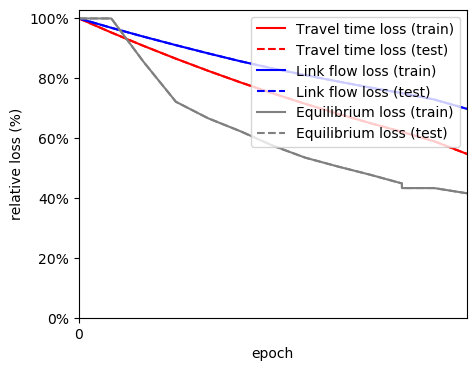

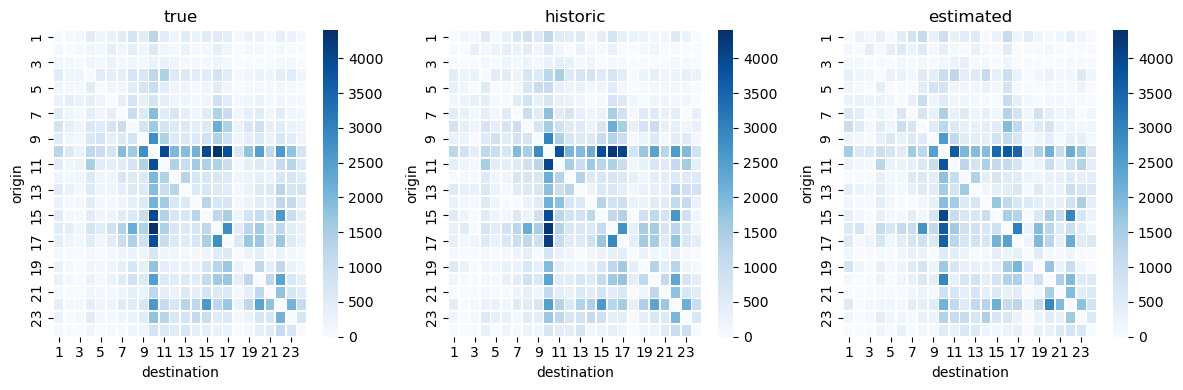

theta = {'tt': -1.0, 'c': -6.0, 's': -3.0}
alpha =  0.15, beta  =  4.00
Avg abs diff of observed and estimated OD:  174.90


In [17]:
if run_model['ode']:
    print('\n ODE: OD estimation with historic OD')

    # _RELATIVE_GAP = 1e-9

    optimizer = tf.keras.optimizers.Adam(learning_rate=_LR)
    # optimizer = tf.keras.optimizers.Adagrad(learning_rate=_LR)

    utility_parameters = UtilityParameters(features_Y=['tt'],
                                           features_Z=features_Z,
                                           periods=1,
                                           initial_values={'tt': -1, 'c': -6, 's': -3, 'psc_factor': 0,
                                                           'fixed_effect': np.zeros_like(tntp_network.links)},
                                           trainables={'psc_factor': False, 'fixed_effect': False
                                               , 'tt': False, 'c': False, 's': False},
                                           )

    bpr_parameters = BPRParameters(keys=['alpha', 'beta'],
                                   initial_values={'alpha': 0.15, 'beta': 4},
                                   trainables=dict.fromkeys(['alpha', 'beta'], False),
                                   )

    Q_historic = isl.factory.random_disturbance_Q(tntp_network.Q, sd=np.mean(tntp_network.Q) * 0.1).copy()

    od_parameters = ODParameters(key='od',
                                 periods=1,
                                 # initial_values=tntp_network.q.flatten(),
                                 initial_values= isl.networks.denseQ(Q_historic).flatten(),
                                 # initial_values=np.ones_like(tntp_network.q.flatten()),
                                 historic_values={1: isl.networks.denseQ(Q_historic).flatten()},
                                 trainable=True)

    equilibrator = Equilibrator(
        network=tntp_network,
        # paths_generator=paths_generator,
        utility=utility_parameters,
        max_iters=100,
        method='fw',
        iters_fw=50,
        accuracy=1e-4,
    )

    ode = GISUELOGIT(
        key='ode',
        network=tntp_network,
        dtype=tf.float64,
        equilibrator=equilibrator,
        utility=utility_parameters,
        bpr=bpr_parameters,
        od=od_parameters,
    )

    train_results_dfs['ode'], val_results_dfs['ode'] = ode.train(
        X_train, Y_train, X_test, Y_test,
        optimizer=optimizer,
        batch_size=_BATCH_SIZE,
        loss_metric=_LOSS_METRIC,
        # generalization_error={'train': False, 'validation': True},
        loss_weights= dict(_LOSS_WEIGHTS),
        momentum_equilibrium = _MOMENTUM_EQUILIBRIUM,
        threshold_relative_gap=_RELATIVE_GAP,
        epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
        epochs=_EPOCHS)

    plot_predictive_performance(train_losses=train_results_dfs['ode'], val_losses=val_results_dfs['ode'],
                                xticks_spacing= 250)

    plt.show()

    Qs = {'true': tntp_network.OD.Q_true, 'historic': Q_historic, 'estimated': tf.sparse.to_dense(ode.Q).numpy()}

    plot_heatmap_demands(Qs=Qs, vmin=np.min(Qs['true']), vmax=np.max(Qs['true']), subplots_dims=(1, 3), figsize=(12, 4))

    plt.show()

    print(f"theta = {dict(zip(utility_parameters.true_values.keys(), list(ode.theta.numpy())))}")
    print(f"alpha = {ode.alpha: 0.2f}, beta  = {ode.beta: 0.2f}")
    print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(ode.q - tntp_network.q.flatten())): 0.2f}")

### Model 4: OD + utility estimation


ODLUE: OD + utility estimation 
Mean of nonzero entries in the original demand matrix:  685.8
Mean absolute difference between the nonzero entries of the noisy and original: 45.5
Approximated proportion change: 6.6%

Epoch: 0, n_train: 80, n_test: 20

0: train_loss=7.5e+07, val_loss=7.5e+07, train_loss tt=7.3e+02, val_loss tt=7.3e+02, train_loss flow=1.9e+07, val_loss flow=1.9e+07, theta = [-1. -6. -3.], vot = 0.17, psc_factor = 0.0, avg abs theta fixed effect = 0, avg alpha=1, avg beta=2, loss demand=1.3e-26, lambda eq=1, relative x=0.72, relative gap=1e-08, train flow equilibrium loss=5.6e+07, time: 0.3

Epoch: 1, n_train: 80, n_test: 20

1: train_loss=1.6e+07, val_loss=1.6e+07, train_loss tt=7.2e+02, val_loss tt=7.2e+02, train_loss flow=1.8e+07, val_loss flow=1.8e+07, theta = [-0.5031 -6.4992 -3.4958], vot = 0.08, psc_factor = 0.0, avg abs theta fixed effect = 0, avg alpha=1, avg beta=2, loss demand=6.6e+02, lambda eq=0.25, relative x=0.61, relative gap=-0.28, train flow equilibriu

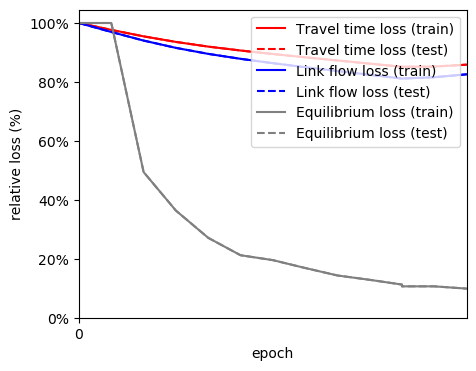

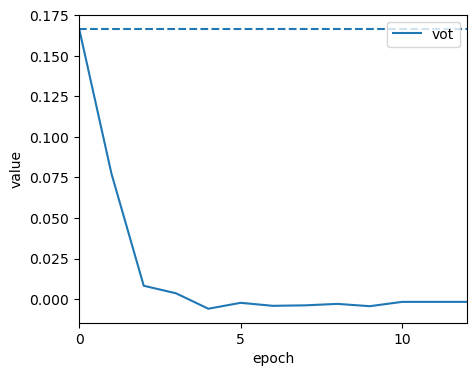

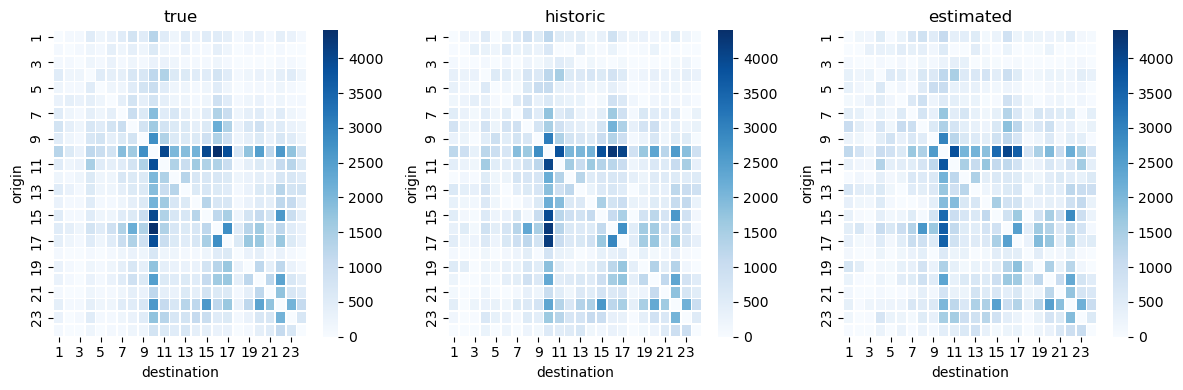

theta = {'tt': 0.009588105658346825, 'c': -5.7476939622388, 's': -6.705299951647093}, vot = -0.00
alpha =  1.00, beta  =  2.00
Avg abs diff of observed and estimated OD:  134.52


In [18]:
if run_model['odlue']:
    print('\nODLUE: OD + utility estimation ')

    # _RELATIVE_GAP = 1e-7

    # optimizer = tf.keras.optimizers.Adagrad(learning_rate=_LR)

    optimizer = tf.keras.optimizers.Adam(learning_rate=_LR)

    utility_parameters = UtilityParameters(features_Y=['tt'],
                                           features_Z=features_Z,
                                           periods=1,
                                           initial_values={'tt': 0, 'c': 0, 's': 0, 'psc_factor': 0,
                                                           'fixed_effect': np.zeros_like(tntp_network.links)},
                                           true_values={'tt': -1, 'c': -6, 's': -3},
                                           # signs={'tt': '-', 'c': '-', 's': '-'},
                                           trainables={'psc_factor': False, 'fixed_effect': False
                                               , 'tt': True, 'c': True, 's': True},
                                           )

    utility_parameters.random_initializer((0,0),['tt','c','s'])
    # utility_parameters.initial_values = dict(utility_parameters.initial_values, tt = -1, c = -1, s = -1)

    bpr_parameters = BPRParameters(keys=['alpha', 'beta'],
                                   initial_values={'alpha': 1, 'beta': 2},
                                   true_values={'alpha': 0.15, 'beta': 4},
                                   trainables=dict.fromkeys(['alpha', 'beta'], False),
                                   )

    Q_historic = isl.factory.random_disturbance_Q(tntp_network.Q, sd=np.mean(tntp_network.Q) * 0.1).copy()

    od_parameters = ODParameters(key='od',
                                 periods=1,
                                 # initial_values=tntp_network.q.flatten(),
                                 initial_values= isl.networks.denseQ(Q_historic).flatten(),
                                 # initial_values=np.ones_like(tntp_network.q.flatten()),
                                 historic_values={1: isl.networks.denseQ(Q_historic).flatten()},
                                 # historic_values={1: tntp_network.q.flatten()},
                                 trainable=True)

    equilibrator = Equilibrator(
        network=tntp_network,
        # paths_generator=paths_generator,
        utility=utility_parameters,
        max_iters=100,
        method='fw',
        iters_fw=50,
        accuracy=1e-4,
    )

    odlue = GISUELOGIT(
        key='odlue',
        network=tntp_network,
        dtype=tf.float64,
        equilibrator=equilibrator,
        utility=utility_parameters,
        bpr=bpr_parameters,
        od=od_parameters,
    )

    train_results_dfs['odlue'], val_results_dfs['odlue'] = odlue.train(
        X_train, Y_train, X_test, Y_test,
        optimizer=optimizer,
        batch_size=_BATCH_SIZE,
        loss_metric=_LOSS_METRIC,
        # generalization_error={'train': False, 'validation': True},
        loss_weights= dict(_LOSS_WEIGHTS),
        momentum_equilibrium = _MOMENTUM_EQUILIBRIUM,
        threshold_relative_gap=_RELATIVE_GAP,
        epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
        epochs=_EPOCHS)

    train_results_estimates, train_results_losses = odlue.split_results(results=train_results_dfs['odlue'])
    val_results_estimates, val_results_losses = odlue.split_results(results=val_results_dfs['odlue'])

    plot_predictive_performance(train_losses= train_results_losses, val_losses=val_results_dfs['odlue'],
                                xticks_spacing = 250)

    plot_convergence_estimates(estimates=train_results_estimates.\
                               assign(vot = train_results_estimates['tt']/train_results_estimates['c'])[['epoch','vot']],
                               true_values={'vot':lue.utility.true_values['tt']/lue.utility.true_values['c']})

    Qs = {'true': tntp_network.OD.Q_true, 'historic': Q_historic, 'estimated': tf.sparse.to_dense(odlue.Q).numpy()}

    plot_heatmap_demands(Qs=Qs, vmin=np.min(Qs['true']), vmax=np.max(Qs['true']), subplots_dims=(1, 3), figsize=(12, 4))

    plt.show()

    print(f"theta = {dict(zip(utility_parameters.true_values.keys(), list(odlue.theta.numpy())))}, "
          f"vot = {train_results_estimates.eval('tt/c').values[-1]:0.2f}")
    print(f"alpha = {odlue.alpha: 0.2f}, beta  = {odlue.beta: 0.2f}")
    print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(odlue.q - tntp_network.q.flatten())): 0.2f}")

## Model 5: ODLUE + link specific performance parameters


ODLULPE: ODLUE + link performance parameters with historic OD matrix
Mean of nonzero entries in the original demand matrix:  687.0
Mean absolute difference between the nonzero entries of the noisy and original: 47.3
Approximated proportion change: 6.9%

Epoch: 0, n_train: 80, n_test: 20

0: train_loss=9.2e+07, val_loss=9.2e+07, train_loss tt=1.1e+04, val_loss tt=1.1e+04, train_loss flow=1.8e+07, val_loss flow=1.8e+07, theta = [-1. -6. -3.], vot = 0.17, psc_factor = 0.0, avg abs theta fixed effect = 0, avg alpha=0.15, avg beta=4, loss demand=1.4e-26, lambda eq=1, relative x=0.76, relative gap=1e-08, train flow equilibrium loss=7.4e+07, time: 0.3

Epoch: 1, n_train: 80, n_test: 20

1: train_loss=1.1e+07, val_loss=1.1e+07, train_loss tt=37, val_loss tt=37, train_loss flow=1.8e+07, val_loss flow=1.8e+07, theta = [-0.5387 -6.4711 -3.4507], vot = 0.08, psc_factor = 0.0, avg abs theta fixed effect = 0, avg alpha=0.093, avg beta=2.5, loss demand=5.1e+02, lambda eq=0.25, relative x=0.38, relat

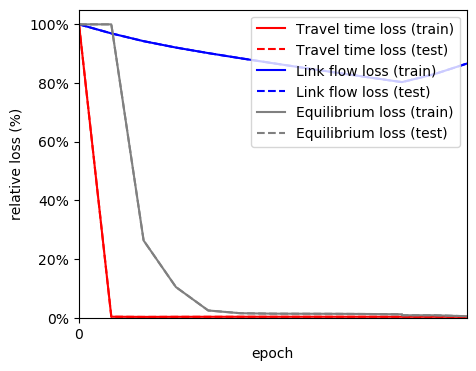

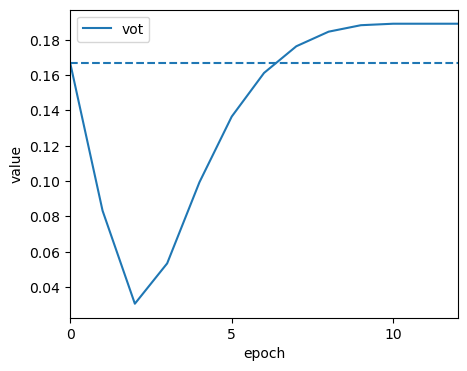

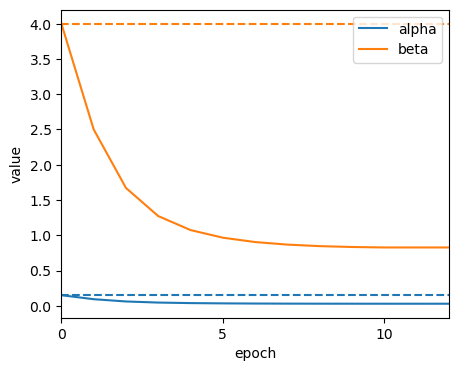

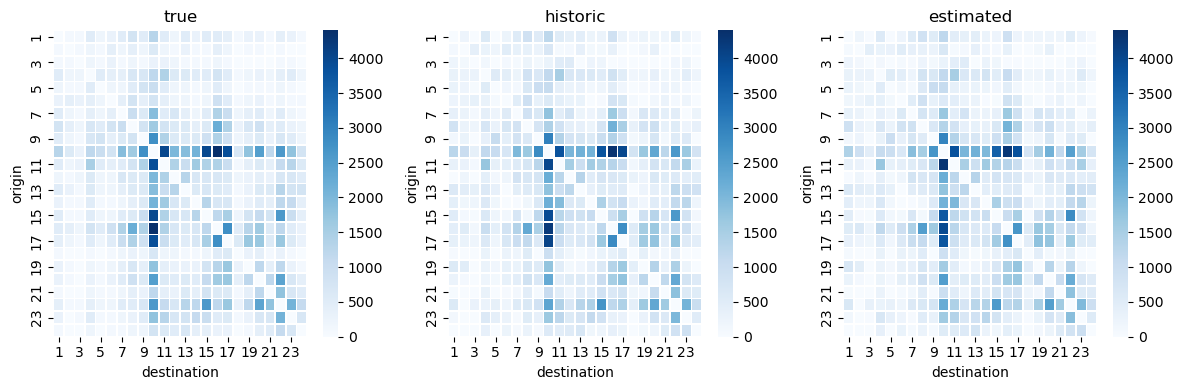

theta = {'tt': -1.1348342841554895, 'c': -6.00106659014655, 's': -4.231671369426321}, vot = 0.19
alpha =  0.03, beta  =  0.83
Avg abs diff of observed and estimated OD:  118.78


In [19]:
if run_model['odlulpe']:
    # _RELATIVE_GAP = 1e-9

    print('\nODLULPE: ODLUE + link performance parameters with historic OD matrix')

    optimizer = tf.keras.optimizers.Adam(learning_rate=_LR)

    bpr_parameters = BPRParameters(keys=['alpha', 'beta'],
                                   # initial_values={'alpha': 0.15, 'beta': 4},
                                   initial_values={'alpha': 1, 'beta': 2},
                                   # initial_values={'alpha': np.ones_like(tntp_network.links, dtype=np.float32),
                                   #                 'beta': 4 * np.ones_like(tntp_network.links, dtype=np.float32)},
                                   true_values={'alpha': 0.15, 'beta': 4},
                                   # initial_values={'alpha': 0.15, 'beta': 4},
                                   trainables={'alpha': True, 'beta':True},
                                   )

    bpr_parameters.random_initializer((0,0),['alpha','beta'])
    # bpr_parameters.random_initializer((-0.15, 0.15), ['alpha'])

    Q_historic = isl.factory.random_disturbance_Q(tntp_network.Q, sd=np.mean(tntp_network.Q) * 0.1).copy()

    od_parameters = ODParameters(key='od',
                                 periods=1,
                                 # initial_values=tntp_network.q.flatten(),
                                 initial_values=isl.networks.denseQ(Q_historic).flatten(),
                                 # initial_values=np.ones_like(tntp_network.q.flatten()),
                                 historic_values={1: isl.networks.denseQ(Q_historic).flatten()},
                                 # historic_values={1: tntp_network.q.flatten()},
                                 trainable=True)

    utility_parameters = UtilityParameters(features_Y=['tt'],
                                           features_Z=features_Z,
                                           periods=1,
                                           initial_values={'tt': 0, 'c': 0, 's': 0, 'psc_factor': 0,
                                                           'fixed_effect': np.zeros_like(tntp_network.links)},
                                           true_values={'tt': -1, 'c': -6, 's': -3},
                                           # signs={'tt': '-', 'c': '-', 's': '-'},
                                           trainables={'psc_factor': False, 'fixed_effect': False
                                               , 'tt': True, 'c': True, 's': True},
                                           )

    utility_parameters.random_initializer((0,0),['tt','c','s'])
    # utility_parameters.initial_values = dict(utility_parameters.initial_values, tt = -1, c = -1, s = -1)

    equilibrator = Equilibrator(
        network=tntp_network,
        # paths_generator=paths_generator,
        utility=utility_parameters,
        max_iters=100,
        method='fw',
        iters_fw=50,
        accuracy=1e-4,
    )

    odlulpe = GISUELOGIT(
        key='odlulpe',
        network=tntp_network,
        dtype=tf.float64,
        equilibrator=equilibrator,
        utility=utility_parameters,
        bpr=bpr_parameters,
        od=od_parameters,
    )

    train_results_dfs['odlulpe'], val_results_dfs['odlulpe'] = odlulpe.train(
        X_train, Y_train, X_test, Y_test,
        optimizer=optimizer,
        # generalization_error={'train': False, 'validation': True},
        batch_size=_BATCH_SIZE,
        loss_weights= dict(_LOSS_WEIGHTS),
        loss_metric=_LOSS_METRIC,
        momentum_equilibrium = _MOMENTUM_EQUILIBRIUM,
        threshold_relative_gap=_RELATIVE_GAP,
        epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
        epochs=_EPOCHS)

    train_results_estimates, train_results_losses = odlulpe.split_results(results=train_results_dfs['odlulpe'])
    val_results_estimates, val_results_losses = odlulpe.split_results(results=val_results_dfs['odlulpe'])

    plot_predictive_performance(train_losses= train_results_losses, val_losses=val_results_dfs['odlulpe'],
                                xticks_spacing = 250)

    plot_convergence_estimates(estimates=train_results_estimates.\
                               assign(vot = train_results_estimates['tt']/train_results_estimates['c'])[['epoch','vot']],
                               true_values={'vot':lue.utility.true_values['tt']/lue.utility.true_values['c']})

    plot_convergence_estimates(estimates=train_results_estimates[['epoch','alpha','beta']],
                               true_values=odlulpe.bpr.true_values)

    Qs = {'true': tntp_network.OD.Q_true, 'historic': Q_historic, 'estimated': tf.sparse.to_dense(odlulpe.Q).numpy()}

    plot_heatmap_demands(Qs=Qs, vmin=np.min(Qs['true']), vmax=np.max(Qs['true']), subplots_dims=(1, 3), figsize=(12, 4))

    plt.show()

    print(f"theta = {dict(zip(utility_parameters.true_values.keys(), list(odlulpe.theta.numpy())))}, "
          f"vot = {train_results_estimates.eval('tt/c').values[-1]:0.2f}")
    print(f"alpha = {np.mean(odlulpe.alpha): 0.2f}, beta  = {np.mean(odlulpe.beta): 0.2f}")
    print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(odlulpe.q - tntp_network.q.flatten())): 0.2f}")

## Write csv file with estimation results

In [20]:
train_results_df, val_results_df \
    = map(lambda x: pd.concat([results.assign(model = model)[['model'] + list(results.columns)]
                               for model, results in x.items()],axis = 0), [train_results_dfs, val_results_dfs])

train_results_df.to_csv(f"./output/tables/{datetime.now().strftime('%y%m%d%H%M%S')}_train_results_{network_name}.csv")
val_results_df.to_csv(f"./output/tables/{datetime.now().strftime('%y%m%d%H%M%S')}_validation_results_{network_name}.csv")


## Plot of convergence toward true vot across models

In [21]:
models = [lue,odlue,odlulpe]

train_estimates = {}
train_losses = {}

for model in models:
    train_estimates[model.key], train_losses[model.key] = model.split_results(results=train_results_dfs[model.key])

    train_estimates[model.key]['model'] = model.key

train_estimates_df = pd.concat(train_estimates.values())

train_estimates_df['vot'] = train_estimates_df['tt']/train_estimates_df['c']

estimates = train_estimates_df[['epoch','model','vot']].reset_index().drop('index',axis = 1)
estimates = estimates[estimates.epoch != 0]

Text(0, 0.5, 'value of time')

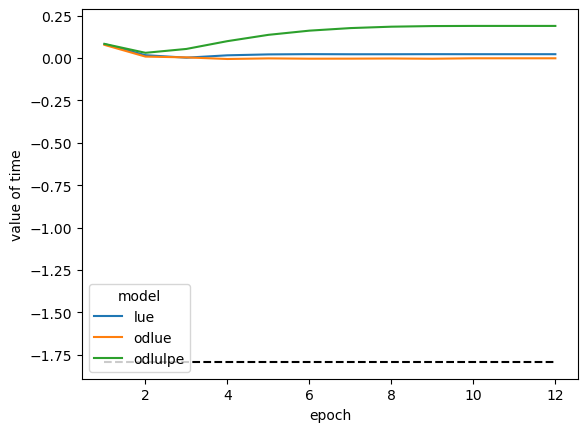

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=1)

g = sns.lineplot(data=estimates, x='epoch', hue='model', y='vot')

ax.hlines(y=np.log(1/6), xmin=estimates['epoch'].min(), xmax=estimates['epoch'].max(), linestyle='--', label = 'truth')

ax.set_ylabel('value of time')
#ax.set_yscale('log')
#plt.ylim(ymin=0)